# Reconocimiento de Instrumento Principal en una Señal de Audio

Este notebook busca desarrollar un algoritmo para detectar el instrumento principal en una señal de audio.

## El Dataset

Será usado el IRMAS Dataset (https://www.upf.edu/web/mtg/irmas).

El dataset se divide en datos de entrenamiento y prueba.

### Datos de entrenamiento

**Archivos de audio:** 6705 archivos de audio en formato wav estéreo de 16 bits muestreados a 44.1kHz. Son extractos de 3 segundos de más de 2000 grabaciones distintas.

**Anotaciones:** la indicación del instrumento predominante de cada extracto está tanto en el nombre de la carpeta contenedora como en el nombre del archivo: cello (cel), clarinete (cla), flauta (flu), guitarra acústica (gac), guitarra eléctrica (gel), órgano (org), piano (pia), saxofón (sax), trompeta (tru), violín (vio) y voz humana (voi). El número de archivos por instrumento es: cel(388), cla(505), flu(451), gac(637), gel(760), org(682), pia(721), sax(626), tru(577), vio(580), voi(778).

Además, algunos de los archivos tienen una anotación en el nombre del archivo con respecto a la presencia ([dru]) o no presencia ([nod]) de la batería, y el género musical: country-folk ([cou_fol]), classical ([cla]) , pop-rock ([pop-roc]), latin-soul ([lat-sou]).

El dataset incluye música actual y del siglo pasado, por lo que se percibe la difierecia en la calidad de audio de algunos extractos. Además, abarca una gran variabilidad en los tipos de instrumentos musicales, intérpretes, articulaciones, así como estilos generales de grabación y producción. Además, tratamos de maximizar la distribución de los géneros musicales dentro de la colección para evitar la extracción de información relacionada con las características del género. Se pagó a dos estudiantes para obtener los datos de 11 instrumentos de las pistas de música preseleccionadas, con el objetivo de extraer extractos que contengan una presencia continua de un único instrumento de destino predominante. Por lo tanto, no se permitió asignar más de un instrumento a un extracto dado.

### Datos de prueba

**Audio:** 2874 extractos en formato wav estéreo de 16 bits muestreados a 44.1kHz.

**Archivos de anotación:** Las anotaciones para un extracto llamado: "excerptName.wav" se dan en "excerptName.txt". Se puede anotar más de un instrumento en cada extracto, una etiqueta por línea.

# Empecemos con el notebook!

# Imports iniciales

In [1]:
# Preaparando los imports
import os
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import pandas as pd
import keras

Using TensorFlow backend.


# Preparacion del Dataset

In [2]:
# Prueba de lectura
rate, data = wav.read("C:/Users/pedri/Downloads/IRMAS-Sample/Training/sax/118__[sax][nod][jaz_blu]1702__3.wav")

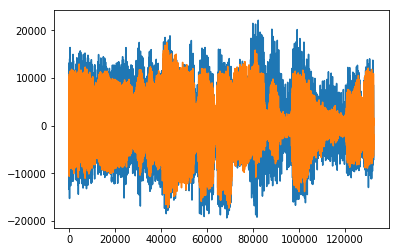

In [3]:
%matplotlib inline
plt.plot(data)
plt.show()

**Nota:** La señal es stereo... Luego observo si esto tiene algún impacto

In [4]:
# Probando la lectura de varios archivos

base_directory = "./IRMAS-TrainingData/"

i=0

for path, dirs, files in os.walk(base_directory):
    for filename in files:
        s = path.split("/")[-1]
        print(s)
        print(os.path.join(path, filename))
        break
        # Just for cheking all the 

cel
./IRMAS-TrainingData/cel\008__[cel][nod][cla]0058__1.wav
cla
./IRMAS-TrainingData/cla\004__[cla][nod][cla]0242__1.wav
flu
./IRMAS-TrainingData/flu\008__[flu][nod][cla]0393__1.wav
gac
./IRMAS-TrainingData/gac\014__[gac][nod][cou_fol]0770__1.wav
gel
./IRMAS-TrainingData/gel\001__[gel][dru][pop_roc]0829__1.wav
org
./IRMAS-TrainingData/org\001__[org][dru][jaz_blu]1123__1.wav
pia
./IRMAS-TrainingData/pia\001__[pia][nod][cla]1389__1.wav
sax
./IRMAS-TrainingData/sax\006__[sax][nod][cla]1686__1.wav
tru
./IRMAS-TrainingData/tru\001__[tru][nod][jaz_blu]1986__1.wav
vio
./IRMAS-TrainingData/vio\001__[vio][nod][cou_fol]2194__1.wav
voi
./IRMAS-TrainingData/voi\001__[voi][dru][pop_roc]2321__1.wav


In [5]:
# Preparar el dataset
instrument_encoding = {
    "cel": 0, 
    "cla": 1, 
    "flu": 2, 
    "gac": 3, 
    "gel": 4, 
    "org": 5, 
    "pia": 6,
    "sax": 7, 
    "tru": 8,
    "vio": 9, 
    "voi": 10
}

start_dir = "./IRMAS-TrainingData/"

dataset = list()

for path, dirs, files in os.walk(start_dir):
    for filename in files:
        row = dict()
        instrument = path.split("/")[-1]
        rate, audio_signal = wav.read(os.path.join(path, filename))
        row["instrument"] = instrument_encoding[instrument]
        row["audio"] = audio_signal
        dataset.append(row)

training_data = pd.DataFrame(dataset)

In [6]:
training_data.head(10)

,audio,instrument
0,"[[-82, 30], [-73, 40], [-62, 49], [-49, 58], [...",0
1,"[[30, 46], [22, 41], [17, 36], [10, 26], [10, ...",0
2,"[[-247, -303], [-224, -294], [-200, -296], [-1...",0
3,"[[-329, 363], [-363, 268], [-423, 174], [-494,...",0
4,"[[28, -596], [-40, -596], [-69, -620], [-189, ...",0
5,"[[814, 337], [877, 442], [884, 410], [866, 239...",0
6,"[[-194, -79], [-158, -45], [-119, -3], [-148, ...",0
7,"[[1113, 1160], [1162, 1205], [1182, 1207], [11...",0
8,"[[-2070, -2096], [-2057, -2088], [-1855, -1910...",0
9,"[[1152, 349], [1213, 489], [1242, 596], [1200,...",0


In [7]:
print(training_data.dtypes)

audio         object
instrument     int64
dtype: object


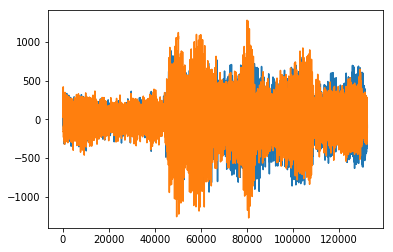

In [8]:
%matplotlib inline
plt.plot(training_data['audio'][0])
plt.show()

**Nota:** Lista la carga de archivos "básica", todavía hace falta estudiar si hacen falta parametros del filename

### Preparando las entradas 

In [9]:
# Getting the training inputs
x_train = training_data['audio']

In [10]:
# Validate the training inputs
print(x_train.shape)

# Remeber we are using stereo signals
print(x_train[0].shape)

(6705,)
(132299, 2)


## Primer problema...

Las entradas no están aptas para las entradas a una CNN... Ya que deben ser convertidas a tensores

Luego de un poco de investiogación, conseguí un paquete de Python recomendado para el manejo de data de audio para el anáñisis de audio y _música_. Ese paquete es **librosa**.

## Librosa
(https://github.com/librosa/librosa)

Esta librería esta bastante respaldada por la comunidad de análisis de señales de audio y música. Algunas de las cosas interesantes que ofrece son:

* Manejo del IO de audio.
* Algoritmos de DSP.
* Visualización de señales de audio, en tiempo y frecuencia.
* Extranción de _features_ de audio (spectrogramas y chromagramas).
* Determinación del _tempo_.
* Filtros y efectos musicales.
* Etc...

Por lo tanto, decido seguir con la recomendación de la comunidad y usar esta librería para el manejo del dataset de audio.


# Preparando el dataset usando librosa

In [11]:
# Imports for the dataset
import librosa
import librosa.display
import librosa.feature

In [12]:
# Some tests
data, sample_rate = librosa.load("C:/Users/pedri/Downloads/IRMAS-Sample/Training/sax/118__[sax][nod][jaz_blu]1702__3.wav")

Populating the interactive namespace from numpy and matplotlib


C:\Users\pedri\Anaconda3\envs\instrument-recognition\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


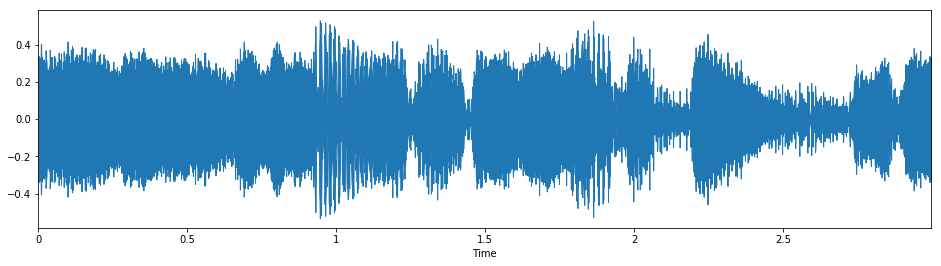

In [13]:
%pylab inline
plt.figure(figsize=(16, 4))
librosa.display.waveplot(data, sr=sample_rate)

In [14]:
# Dataset read function
training_dir = "./IRMAS-TrainingData/"

def read_audio_dataset(start_directory):
    start_dir = start_directory
    dataset = list()
    for path, dirs, files in os.walk(start_dir):
        for filename in files:
            row = dict()
            instrument = path.split("/")[-1]
            row["instrument"] = instrument_encoding[instrument]
            row["audio_file"] = os.path.join(path, filename)
            dataset.append(row)
    return dataset

In [15]:
# Loadning the dataset

dataset = pd.DataFrame(read_audio_dataset(training_dir))

dataset.head(10)

,audio_file,instrument
0,./IRMAS-TrainingData/cel\008__[cel][nod][cla]0...,0
1,./IRMAS-TrainingData/cel\008__[cel][nod][cla]0...,0
2,./IRMAS-TrainingData/cel\008__[cel][nod][cla]0...,0
3,./IRMAS-TrainingData/cel\012__[cel][nod][cla]0...,0
4,./IRMAS-TrainingData/cel\012__[cel][nod][cla]0...,0
5,./IRMAS-TrainingData/cel\012__[cel][nod][cla]0...,0
6,./IRMAS-TrainingData/cel\013__[cel][nod][cla]0...,0
7,./IRMAS-TrainingData/cel\013__[cel][nod][cla]0...,0
8,./IRMAS-TrainingData/cel\013__[cel][nod][cla]0...,0
9,./IRMAS-TrainingData/cel\014__[cel][nod][cla]0...,0


In [16]:
# Preapring a parser

def parser(row):
    num_mfcc = 100
   # function to load files and extract features
    file_name = row['audio_file']

   # handle exception to check if there isn't a file which is corrupted
    try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_mfcc).T,axis=0) 
    except Exception as e:
      print("Error encountered while parsing file: ", file)
      return None, None
    
    feature = mfccs
    instrument = row[1]
 
    return [feature, instrument]

### MFCC

Los Mel Frequency Cepstral Coefficients (Coeﬁcientes Cepstrales en las Frecuencias de Mel) o MFCCs son coeﬁcientes para la representación del habla basados en la percepción auditiva humana. Estos surgen de la necesidad, en el área del reconocimiento de audio automático, de extraer características de las componentes de una señal de audio que sean adecuadas para la identificación de contenido relevante, así como obviar todas aquellas que posean información poco valiosa como el ruido de fondo, emociones, volumen, tono, etc. y que no aportan nada al proceso de reconocimiento, al contrario lo empobrecen.

**Extraido de Wikipedia** (https://es.wikipedia.org/wiki/MFCC)

In [17]:
# Create the training dataset
train = dataset.apply(parser, axis=1)

In [18]:
# Fixing the columns name
train.columns = ['feature', 'instrument']
train.head(10)

,feature,instrument
0,"[-504.139434973, 146.599657138, -29.1971492038...",0
1,"[-450.837263914, 132.518278686, -31.9897767804...",0
2,"[-404.966760666, 121.834832995, -37.6514889456...",0
3,"[-317.247056649, 135.267460654, -29.4179305056...",0
4,"[-311.622976115, 125.683183809, -32.9319603227...",0
5,"[-297.162067147, 113.015259088, -38.260997353,...",0
6,"[-302.339151003, 135.015977194, -32.4488141208...",0
7,"[-308.820472202, 148.06053619, -30.6829171531,...",0
8,"[-287.93103379, 133.258676304, -47.8903762317,...",0
9,"[-276.066085, 121.044045867, -29.8171406129, 3...",0


In [22]:
train.feature[0].shape

(100,)

### Preparar un set de validación

In [23]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train, test_size=0.1)

C:\Users\pedri\Anaconda3\envs\instrument-recognition\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
print(train_set.shape)

print(val_set.shape)

(6034, 2)
(671, 2)


In [25]:
x_train = np.array(train_set.feature.tolist())
x_val = np.array(val_set.feature.tolist())

### One-hot encoding para las salidas

In [26]:
# Specifying the length of the array
num_classes = len(instrument_encoding)

# One-hot!
y_train = keras.utils.to_categorical(train_set['instrument'], num_classes)
y_val = keras.utils.to_categorical(val_set['instrument'], num_classes)

In [27]:
# Validating the one-hot encoding
print(y_train.shape)
# The result should be (# of training examples, # of instruments)

print(y_val.shape)

(6034, 11)
(671, 11)


## Ahora con el Set de Prueba

In [33]:
testing_dir = "./IRMAS-TestingData/Part1/"

# We create a function for reading the dataset

def read_testing_data(start_directory):
    dataset = list()
    for path, dirs, files in os.walk(start_directory):
        for filename in files:
            row = dict()
            if ".wav" in filename:
                s = os.path.join(path, filename)
                row["audio_file"] = s
                txt_file = ''
                for i in range(len(s.split("."))-2):
                    txt_file += "." + s.split(".")[i+1]
                txt_file += ".txt"
                
                with open(txt_file, "r") as f:
                    instruments = f.read()
                    instruments = instruments.replace("\t", '').splitlines()
                    for idx, instrument in enumerate(instruments):
                        instruments[idx] = instrument_encoding[instrument]
                row["instruments"] = instruments
                dataset.append(row)
    return dataset

In [34]:
test_dataset = pd.DataFrame(read_testing_data(testing_dir))

test_dataset.head(10)

,audio_file,instruments
0,./IRMAS-TestingData/Part1/(02) dont kill the w...,[4]
1,./IRMAS-TestingData/Part1/(02) dont kill the w...,[4]
2,./IRMAS-TestingData/Part1/(02) dont kill the w...,"[4, 10]"
3,./IRMAS-TestingData/Part1/(02) dont kill the w...,"[4, 10]"
4,./IRMAS-TestingData/Part1/(02) dont kill the w...,"[4, 10]"
5,./IRMAS-TestingData/Part1/(02) dont kill the w...,"[4, 6]"
6,./IRMAS-TestingData/Part1/(02) dont kill the w...,"[4, 10]"
7,./IRMAS-TestingData/Part1/(02) dont kill the w...,"[4, 10]"
8,./IRMAS-TestingData/Part1/(02) dont kill the w...,[4]
9,./IRMAS-TestingData/Part1/(02) dont kill the w...,"[4, 10]"


In [35]:
# Create the testing dataset
test = test_dataset.apply(parser, axis=1)

In [36]:
# Fixing the columns name
test.columns = ['feature', 'instruments']
test.head(10)

,feature,instruments
0,"[-90.7780702638, 132.792370918, -49.32456321, ...",[4]
1,"[-41.5902087434, 124.775037373, -33.3927928355...",[4]
2,"[-1.36547718103, 110.355824649, -44.7647900441...","[4, 10]"
3,"[0.575872664507, 107.774237792, -42.3118069346...","[4, 10]"
4,"[-1.42795916602, 101.563236337, -35.5372230685...","[4, 10]"
5,"[4.85285643358, 115.228389468, -50.394318925, ...","[4, 6]"
6,"[-69.1302221266, 130.401432863, -40.1972724285...","[4, 10]"
7,"[-34.2556355019, 116.853588909, -34.694472774,...","[4, 10]"
8,"[-42.6241912576, 127.101141725, -40.7307919378...",[4]
9,"[-28.2977147811, 114.067457177, -34.4083805267...","[4, 10]"


# Preparemos la CNN

**Nota:** El data set es de archivos de audio en **stereo** por lo tanto es necesario validar 2 cosas:
1. ¿Es mejor usar _features_ y una NN Densa?
2. ¿Resultaría conveniente transformar los archivo de stereo a mono y usar una CNN sobre el spectrograma de frecuencias?

#### Busquemos respuestas!

### Imports para C/NN

In [37]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D

In [82]:
def build_NN_model(num_instruments, neurons_in_hlayer, num_layers=1,activation='relu', dropout=0.5):
    model = Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    for i in range(num_layers):
        model.add(Dense(neurons_in_hlayer))
        model.add(Activation(activation))
        model.add(Dropout(dropout))
    model.add(Dense(num_instruments))
    model.add(Activation('softmax'))
    return model

In [83]:
nn_model = build_NN_model(y_train.shape[1], 2560)
nn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Listo para entrenar!

In [80]:
from fnn_helper import PlotLosses
from keras.callbacks import ModelCheckpoint
# Preparing the cool graphics helper
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val)

# Preparing for early stop
checkpointer = ModelCheckpoint(filepath='nn_2layer_model.hdf5', verbose=0, save_best_only=True)

### Prueba 1

* `batch_size = 32`
* `epochs = 300`
* `num_layers = 1`
* `neurons_in_hlayer = 2560`

Son parametros bastante sencillos, muy similares a los usados en clase.

Vale la pena probar con `batch_size` superior... Según la literatura puede mejorar la precisión a costa de memoria RAM.

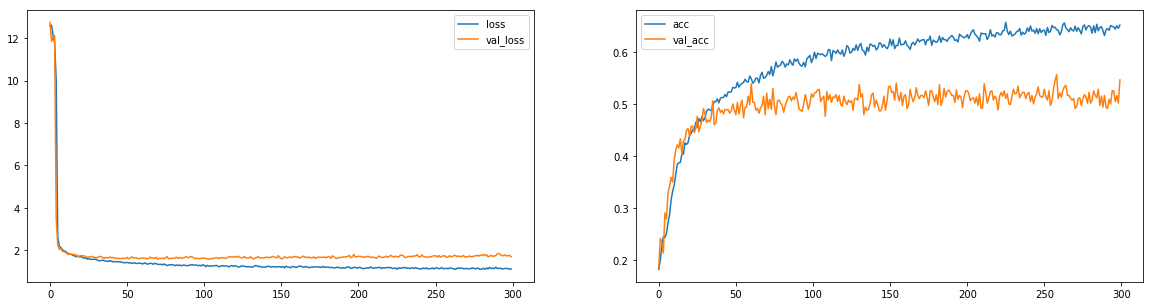

 - 4s - loss: 1.1045 - acc: 0.6528 - val_loss: 1.6880 - val_acc: 0.5469


In [81]:
# Training
nn_model.fit(x_train, y_train, 
    batch_size=32, 
    epochs=300,
    validation_data=(x_val, y_val), 
    verbose=2,
    callbacks=[plot_losses, checkpointer])

## Evaluemos el modelo!

In [84]:
# Select the BEST!
nn_model.load_weights('nn_2layer_model.hdf5')

predictions = nn_model.predict(np.array(test.feature.tolist()))

In [85]:
predicted_instruments = np.argmax(predictions, axis=1)

In [86]:
test['predicted'] = predicted_instruments

In [87]:
acum = 0
for i in range(test.shape[0]):
    if test.predicted[i] in test.instruments[i]:
        acum += 1

print(acum/test.shape[0])

0.5439900867410161


### Prueba 2

* `batch_size = 64`
* `epochs = 2000` 
* ~~`num_layers = 2`~~ Esto fue un _overkill_ `num_layers = 1`
* `neurons_in_hlayer = 2560` 

Una prueba mucho más _violenta_ para evaluar antes de pasar a otro método

In [94]:
nn_model_2 = build_NN_model(y_train.shape[1], 
                          neurons_in_hlayer=2560,
                          num_layers=1)
nn_model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Preparing for early stop
checkpointer = ModelCheckpoint(filepath='nn_3layer_model.hdf5', verbose=0, save_best_only=True)

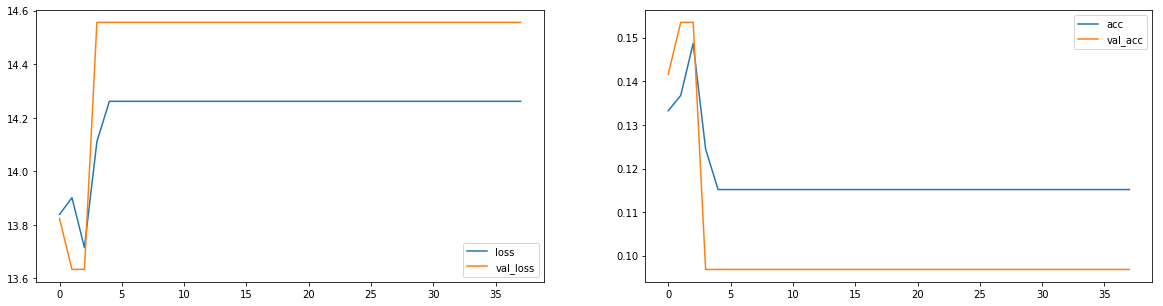

 - 18s - loss: 14.2616 - acc: 0.1152 - val_loss: 14.5567 - val_acc: 0.0969
Epoch 39/2000


KeyboardInterrupt: 

In [93]:
# This was a HORRIBLE test... It's here for the record...
nn_model_2.fit(x_train, y_train, 
    batch_size=64, 
    epochs=2000,
    validation_data=(x_val, y_val), 
    verbose=2,
    callbacks=[plot_losses, checkpointer])

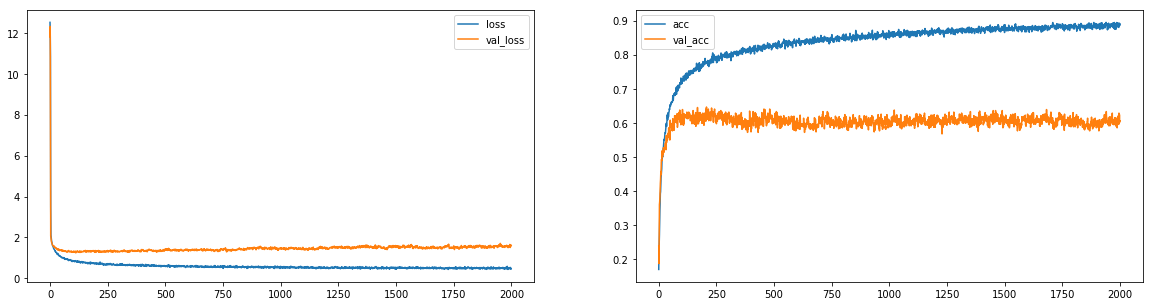

 - 2s - loss: 0.4708 - acc: 0.8896 - val_loss: 1.6080 - val_acc: 0.6066


In [95]:
nn_model_2.fit(x_train, y_train, 
    batch_size=64, 
    epochs=2000,
    validation_data=(x_val, y_val), 
    verbose=2,
    callbacks=[plot_losses, checkpointer])

In [96]:
# Select the BEST!
nn_model_2.load_weights('nn_3layer_model.hdf5')

predictions = nn_model_2.predict(np.array(test.feature.tolist()))

In [97]:
predicted_instruments = np.argmax(predictions, axis=1)

In [98]:
test['predicted'] = predicted_instruments

In [99]:
acum = 0
for i in range(test.shape[0]):
    if test.predicted[i] in test.instruments[i]:
        acum += 1

print(acum/test.shape[0])

0.5613382899628253


### Prueba 3

* `batch_size = 256`
* `epochs = 2000` 
* `num_layers = 1`
* `neurons_in_hlayer = 2560` 

Efectivamente el `batch_size` mejora mucho

In [100]:
nn_model_3 = build_NN_model(y_train.shape[1], 
                          neurons_in_hlayer=2560,
                          num_layers=1)
nn_model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Preparing for early stop
checkpointer = ModelCheckpoint(filepath='nn_2layer_model_bs256.hdf5', verbose=0, save_best_only=True)

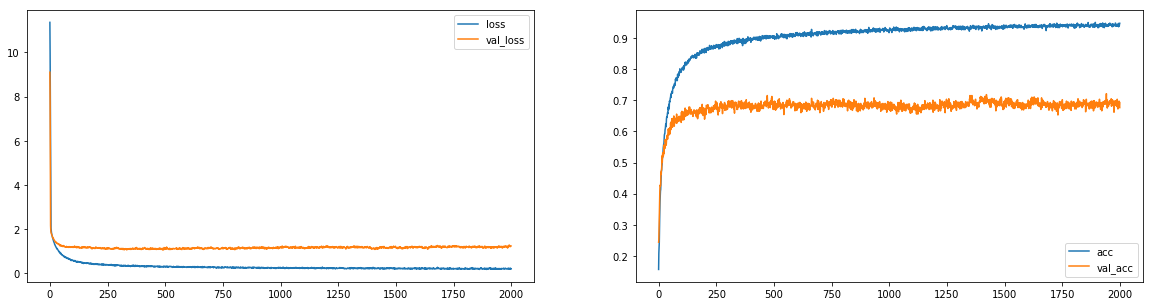

 - 2s - loss: 0.2006 - acc: 0.9473 - val_loss: 1.2402 - val_acc: 0.6766


In [101]:
nn_model_3.fit(x_train, y_train, 
    batch_size=256, 
    epochs=2000,
    validation_data=(x_val, y_val), 
    verbose=2,
    callbacks=[plot_losses, checkpointer])

In [102]:
# Select the BEST!
nn_model_3.load_weights('nn_2layer_model_bs256.hdf5')

predictions = nn_model_3.predict(np.array(test.feature.tolist()))

In [103]:
predicted_instruments = np.argmax(predictions, axis=1)

In [104]:
test['predicted'] = predicted_instruments

In [105]:
acum = 0
for i in range(test.shape[0]):
    if test.predicted[i] in test.instruments[i]:
        acum += 1

print(acum/test.shape[0])

0.5192069392812887
